In [1]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [2]:
# Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length):
        self.data = pd.read_csv(file_path)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = 1 if self.data.iloc[idx]['label'] == 'hate' else 0

        inputs = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, truncation=True, padding=True)
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        hatespeech_dataset = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.float32)
        }

        return hatespeech_dataset

In [3]:
# Collate function
def my_collate_fn(batch):
    # Assuming each sample is a dictionary with 'input_ids', 'attention_mask', and 'label' keys
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.float)

    # Pad sequences to the length of the longest sequence in the batch
    padded_input_ids = pad_sequence(input_ids, batch_first=True)
    padded_attention_masks = pad_sequence(attention_masks, batch_first=True)

    return {
        'input_ids': padded_input_ids,
        'attention_mask': padded_attention_masks,
        'label': labels
    }

In [4]:
# Tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # Binary classification, so num_labels=1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Dataset and dataloader
file_path = "C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_train.csv"
max_length = 512
batch_size = 32

dataset = HateSpeechDataset(file_path, tokenizer, max_length)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=my_collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=my_collate_fn, shuffle=False)

In [6]:
# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Training loop
epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

avg_train_losses = []
avg_val_losses = []

for epoch in range(epochs):

    model.train()

    for batch in train_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits.squeeze(), labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        # print(f'Epoch: {epoch + 1}, Batch Loss: {loss.item()}')

    # Evaluation loop
    model.eval()

    with torch.no_grad():

      val_labels = []
      val_predictions = []

      for batch in val_loader:

          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          outputs = model(input_ids, attention_mask=attention_mask)
          loss = criterion(outputs.logits.squeeze(), labels)
          val_losses.append(loss.item())

          val_labels.extend(labels.cpu().numpy())
          val_predictions.extend(torch.sigmoid(outputs.logits).cpu().numpy())


    # Print average training loss for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_losses.append(avg_train_loss)
    print(f'Epoch: {epoch + 1}, Average Training Loss: {avg_train_loss}')

    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_losses.append(avg_val_loss)
    print(f'Validation Loss: {avg_val_loss}')

Epoch: 1, Batch Loss: 0.7145931720733643
Epoch: 1, Batch Loss: 0.6736264228820801
Epoch: 1, Batch Loss: 0.7178807258605957
Epoch: 1, Batch Loss: 0.695183515548706
Epoch: 1, Batch Loss: 0.6988535523414612
Epoch: 1, Batch Loss: 0.6830277442932129
Epoch: 1, Batch Loss: 0.6956261992454529
Epoch: 1, Batch Loss: 0.7106565833091736
Epoch: 1, Batch Loss: 0.6704666614532471
Epoch: 1, Batch Loss: 0.6765016317367554
Epoch: 1, Batch Loss: 0.6643799543380737
Epoch: 1, Batch Loss: 0.6821513175964355
Epoch: 1, Batch Loss: 0.6633620262145996
Epoch: 1, Batch Loss: 0.6499161124229431
Epoch: 1, Batch Loss: 0.637907087802887
Epoch: 1, Batch Loss: 0.6024869680404663
Epoch: 1, Batch Loss: 0.6443766951560974
Epoch: 1, Batch Loss: 0.696735680103302
Epoch: 1, Batch Loss: 0.6418275237083435
Epoch: 1, Batch Loss: 0.590551495552063
Epoch: 1, Batch Loss: 0.6277140974998474
Epoch: 1, Batch Loss: 0.600423276424408
Epoch: 1, Batch Loss: 0.6297922134399414
Epoch: 1, Batch Loss: 0.7022902369499207
Epoch: 1, Batch Loss:

In [2]:
import seaborn as sns

# plot results
def plot_results():
    # styling from seaborn.
    sns.set(style='darkgrid')
    # uncrease the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # plot the learning curve.
    plt.plot(avg_train_losses, 'b-o', label="Training")
    plt.plot(avg_val_losses, 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(list(range(1, epochs+1)))
    return plt.show()


plot_results()

NameError: name 'df_stats' is not defined

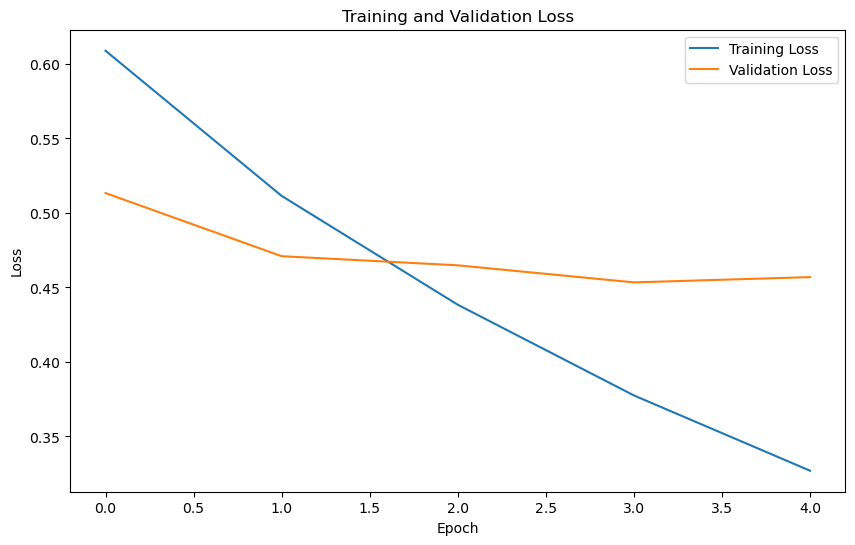

In [8]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()